In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
from scipy import stats 
import env
import wrangle
import explore
from itertools import combinations
from math import sqrt

from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


# Zillow Project

# Executive Summary

- The factors that most drive tax value dollar count (sell price) are total square feet, bedroom count, age, and location
- The polynomial regression model that we will talk about later is more accurate than our baseline by around $100,000

# The plan for this presentation: 
- Attempt to explain what factors can be used to predict the sell price of single family residential units  by doing the following:
    - Acquire and prepare the data
    - Explore the different factors that could contribute to the sell price
    - Try out a few different models
    - Offer final recommendations 

# Acquiring and Preparing the data

### This wrangle function acquires the data and prepares it by doing the following:

- acquires Single Family Residential units from the properties_2017, propertylandusetype, and predictions_2017 tables, which was taken from the Zillow database
- drops the na values to get rid of nulls 
- converts the columns bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, and yearbuilt to int columns
- gets rid of properties that have zero bedrooms or more than 6 bedrooms
- gets rid of properties that have zero bathrooms or more than 6 bathrooms
- gets rid of properties where the taxvaluedollarcount (sell price) exceeds 4,000,000
- gets rid of properties where the calculated finished square feet is over 100,000

#### This is so we can get a picture of what a regular consumer would be buying, and our data won't be skewed by homes that the average consumer wouldn't be purchasing.

- adds a fips two colummn that gives the name of the county that is represented by the fips number: 
    - 6037 = LA 
    - 6059 = Orange 
    - 6111 = Ventura
- adds an age column, that gives the age of the property in years

In [2]:
# calling the wrangle function from the wrangle.py file
df = wrangle.wrangle_zillow()

In [3]:
# ensuring all columns were brought over
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid,age,fips2
0,4,2.5,2490,691000,1969,7138.64,Orange,14381521,53,6059
1,4,2.0,1808,241131,1980,3589.81,LA,11108702,42,6037
2,4,2.0,1878,94598,1965,1415.77,LA,10728687,57,6037
3,4,2.0,1207,380736,1964,3869.62,Orange,14376191,58,6059
4,2,1.0,728,33497,1925,974.63,LA,12391744,97,6037


In [4]:
# ensuring data was pulled over
df.shape

(51702, 10)

In [5]:
# checking for nulls 
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
parcelid                        0
age                             0
fips2                           0
dtype: int64

<div class="alert alert-block alert-success">
<b>Success:</b> All data was pulled and prepared as expected.
</div>

# Split the Data

In [6]:
# This function pulls from the wrangle.py file and splits the data into train, validate, and test
# This will be used in the exploration

train, validate, test = wrangle.split_zillow_data(df)

train.shape, validate.shape, test.shape

((28952, 10), (12409, 10), (10341, 10))

In [7]:
# we will go ahead and scale the data to use later on for the machine learning portion
train_s, validate_s, test_s = wrangle.data_scaled(train, validate, test, columns_to_scale=(df.drop(columns = ['fips', 'taxvaluedollarcnt']).columns))
train_s.shape, validate_s.shape, test_s.shape

((28952, 10), (12409, 10), (10341, 10))

<div class="alert alert-block alert-success">
<b>Success:</b> Data was split into train, validate, test samples as expected.
</div>

# Exploration


### What factors can be used to help predict the sell price of single family residential properties?

<div class="alert alert-block alert-warning">
    
<b>Initial Hypotheses:</b> 

- county (fips) has a strong relationship with tax value dollar count (sell price)
    
- calculated finished square feet (sqft) has a strong relationship with sell price
    
- newer homes have a higher sell price 
    
- homes with more bedrooms and bathrooms have a higher sell price (probably has a strong correlation with sqft)
    
- LA county has the highest value homes, followed by Orange county and then Ventura county
</div>

In [8]:
# let's see what columns may be correlated to our target variable
columns_corr = train.corr()
columns_corr.taxvaluedollarcnt

bedroomcnt                      0.277196
bathroomcnt                     0.533649
calculatedfinishedsquarefeet    0.602603
taxvaluedollarcnt               1.000000
yearbuilt                       0.221701
taxamount                       0.982508
parcelid                        0.030878
age                            -0.221701
fips2                           0.059124
Name: taxvaluedollarcnt, dtype: float64

- Takeaways: 

- The closer that a value is to one, the more similar it is to our target variable, which is the tax value dollar count

- When looking at the tax value dollar count, we can see that it is strongly related to tax amount. This strong of a relationship would skew our analysis, so when looking for our target variable we will be ignoring the tax amount. 
- We can also see that year built and age are inverses of each other, so we won't be using both of these factors at the same time. 

In [9]:
# Here I am going to create 3 different variables. The first (or base) will contain just the bathroom count, bedroom count, age, and square feet
# The second will contain the same as the first, but with the tax value dollar count
# The third will contain the base, but with the fips county names
interest_vars_base= (train.bedroomcnt, train.bathroomcnt, train.calculatedfinishedsquarefeet, train.age)
interest_vars_v= (train.bedroomcnt, train.bathroomcnt, train.calculatedfinishedsquarefeet, train.age, train.taxvaluedollarcnt)
interest_vars_f = (train.bedroomcnt, train.bathroomcnt, train.calculatedfinishedsquarefeet, train.age, train.fips)

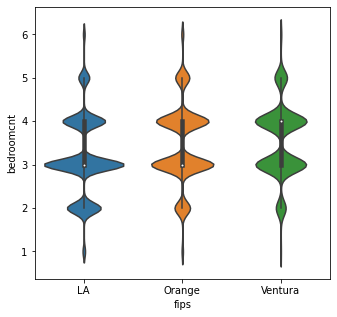

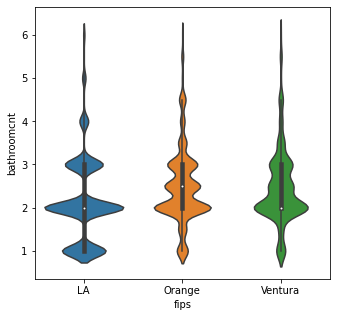

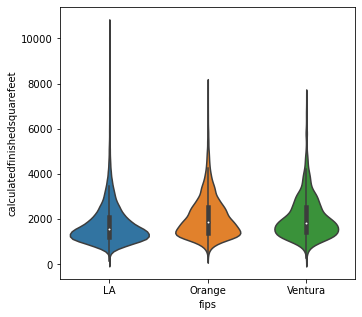

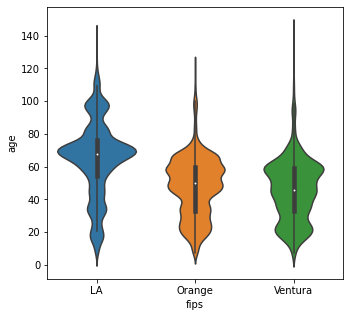

In [10]:
# I want to look at each county against my base variables 
explore.fips_vs_continuous_vars(train, interest_vars_base,['fips'])

Takeaways: 
- Most homes in LA county are 3 beds while homes in Orange county and Ventura county are more evenly distributed between 3 and 4 bedrooms
- Most homes either have 2 or 3 bathrooms, but LA county has a larger percentage houses with only one bathroom than the other two counties. 
- Homes in LA county tend to have a smaller average square foot size than homes in Ventura county and Orange county
- On average, homes in Ventura county and Orange county seem to be newer than homes in LA county



## Examine the relationship between age and tax value dollar count in each county.



#### Does the age of the home have an impact on the tax value dollar count?
Hypothesis

 H0= There is no relationship between age and taxvaluedollarcnt.

 H1= There is a relationship between age and taxvaluedollarcnt.

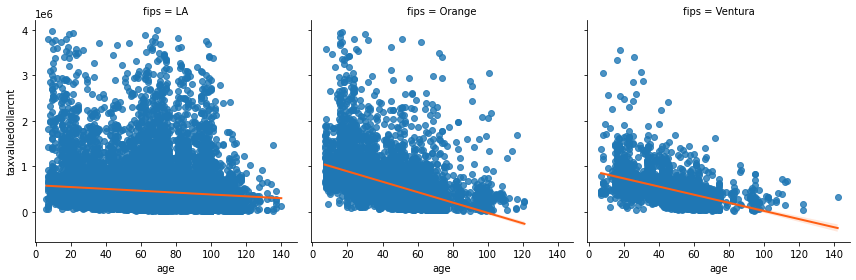

In [11]:
# Run an lm plot for age against tax value dollar count to see possible trends
sns.lmplot(x = 'age', y = 'taxvaluedollarcnt', data = train, line_kws={'color': '#FF5E13', 'linewidth': 2}, height = 4, col = 'fips')

In [12]:
# run statistical test to see if there is, in fact, a relationship between the two variables
alpha = .05
corr, p = stats.pearsonr(train.age, train.taxvaluedollarcnt)
p< alpha, p, corr


(True, 3.0717e-319, -0.22170107312039883)

In [13]:
if p < alpha:
    print ('I reject the null hypothesis.')
else:
        print('I accept the null hypothesis.')

I reject the null hypothesis.


Takeaways: 
- There is a correlation between age and the tax value dollar count
- Properties in LA county seem to hold their value significantly better as they age versus properties in Orange county and Ventura county

### Examine the relationship between square feet and tax value dollar count in each county.

#### Does the square footage of the home have an impact on the tax value dollar count?

Hypothesis

 H0= There is no relationship between square footage and taxvaluedollarcnt.

 H1= There is a relationship between square footage and taxvaluedollarcnt.

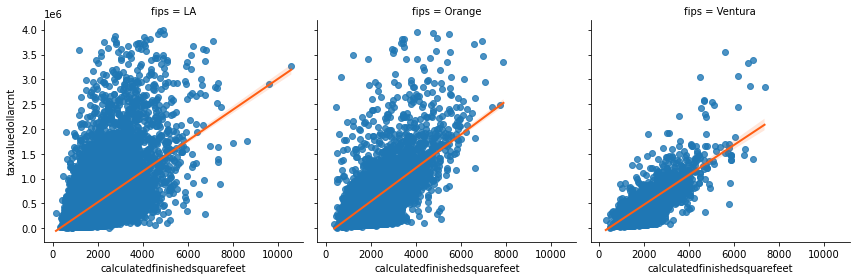

In [14]:
#lm plot for calculated finished square feet and tax value dollar count
sns.lmplot(x = 'calculatedfinishedsquarefeet', y = 'taxvaluedollarcnt', data = train, line_kws={'color': '#FF5E13', 'linewidth': 2}, height = 4, col = 'fips')

In [15]:
# run statistical test to see if there is, in fact, a relationship between the two variables
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
p< alpha, p, corr


(True, 0.0, 0.6026034514097558)

In [16]:
if p < alpha:
    print ('I reject the null hypothesis.')
else:
        print('I accept the null hypothesis.')

I reject the null hypothesis.


Takeaways: 
- There is a correlation between square footage and the tax value dollar count

### Examine the relationship between number of bedrooms and tax value dollar count in each county.

#### Does the number of bedrooms of the home have an impact on the tax value dollar count?

Hypothesis

 H0= There is no relationship between the number of bedrooms and taxvaluedollarcnt.

 H1= There is a relationship between the number of bedrooms and taxvaluedollarcnt.

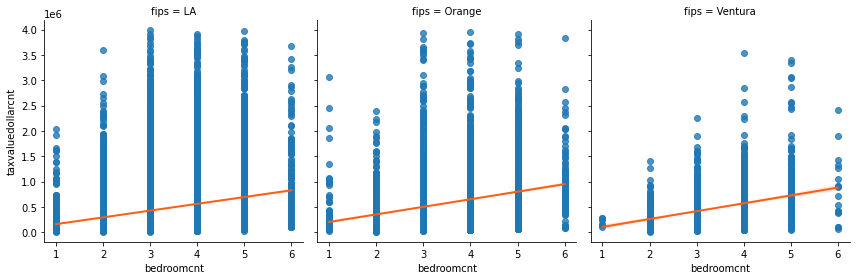

In [17]:
# creating an lm plot to see if there is a relationship between bedroom count and tax value dollar count
sns.lmplot(x = 'bedroomcnt', y = 'taxvaluedollarcnt', data = train, line_kws={'color': '#FF5E13', 'linewidth': 2}, height = 4, col = 'fips')

In [18]:
# run statistical test to see if there is, in fact, a relationship between the two variables
corr, p = stats.pearsonr(train.bedroomcnt, train.taxvaluedollarcnt)
p< alpha, p, corr

(True, 0.0, 0.27719643069472344)

In [19]:
if p < alpha:
    print ('I reject the null hypothesis.')
else:
        print('I accept the null hypothesis.')

I reject the null hypothesis.


Takeaways: 
- There is a correlation between number of bedrooms and the tax value dollar count
- Stronger relationship than the age of the home, but weaker than the calculated square feet

### Examine the relationship between county and tax value dollar count.

#### Does the number of county have an impact on the tax value dollar count?

Hypothesis

 H0= There is no relationship between the county and taxvaluedollarcnt.

 H1= There is a relationship between the county and taxvaluedollarcnt.

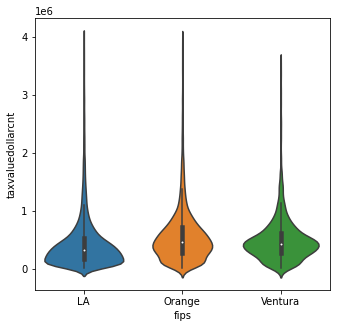

In [20]:
# create a violin plot to visualize relationship between the county of the property and tax value dollar count
# This plot pulls from my explore.py file, which holds the code for the plot
explore.fips_vs_continuous_vars(train, ['taxvaluedollarcnt'],['fips'])

In [21]:
# run statistical test to see if there is, in fact, a relationship between the two variables
corr, p = stats.pearsonr(train.fips2, train.taxvaluedollarcnt)
p< alpha, p, corr

(True, 7.607280261777359e-24, 0.05912448191990963)

In [22]:
if p < alpha:
    print ('I reject the null hypothesis.')
else:
        print('I accept the null hypothesis.')

I reject the null hypothesis.


Takeaways: 
- There is a correlation between the county the home is located in and the tax value dollar count of the home
- LA county actually seems to have a lower tax value dollar count than both Orange County and Ventura county

<div class="alert alert-block alert-success">
<b>Takeaways:</b> 
    
- The selling price of a property is related to the age of the property, the calculated square footage of the property, the bedroom count of the property, and which county the property is located in. 
    
- The calculated square footage of the property seems to have the strongest relationship with the selling price of the property, followed by bedroom count, then the age of the property, then the location of the property.
    
- It turns out that Orange county and Ventura county have higher average values for their selling price, which is the opposite of our initial hypothesis that LA county would have a higher average selling price. 
</div>

# Modeling

<div class="alert alert-block alert-warning">
- Throughout my modeling, I tested a few different models. The ones that performed the best were my polynomial regression model, then my linear regression model and my lassolars model
<br>

#### The features that I want to use for modeling are bedroom count, the age of the property, the square footage of the property, and the bathroom count of the property, since these most appeared to drive the tax value dollar count in my exploration phase

In [24]:
# Stratify with taxvaluedollarcnt using the scaled data
X_train = train_s[['bedroomcnt', 'age' , 'calculatedfinishedsquarefeet', 'bathroomcnt']]
y_train = pd.DataFrame(train_s.taxvaluedollarcnt)

X_validate = validate_s[['bedroomcnt', 'age' , 'calculatedfinishedsquarefeet', 'bathroomcnt']]
y_validate = pd.DataFrame(validate_s.taxvaluedollarcnt)

X_test = test_s[['bedroomcnt', 'age' , 'calculatedfinishedsquarefeet', 'bathroomcnt']]
y_test = pd.DataFrame(test_s.taxvaluedollarcnt)

In [25]:
#establishing the baseline and making a column for it in train, test, and validate
taxvalue_mean = y_train.taxvaluedollarcnt.mean()
y_train['taxvalue_pred_mean'] = taxvalue_mean
y_validate['taxvalue_pred_mean'] = taxvalue_mean
y_test['taxvalue_pred_mean'] = taxvalue_mean

In [33]:
#calculated my rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  468046.11 
Validate/Out-of-Sample:  465173.0


This will be my initial baseline that I will use to test my other models.

# Polynomial Regression - Best Model

In [27]:
# I ended up choosing a degree of 2 to avoid any overfitting
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [28]:
# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# train
y_train['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2)

# get my rmse value for train
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm2)**(1/2)

# validate
y_validate['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2)

# get my rmse rmse for validate
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  359830.98382565303 
Validation/Out-of-Sample:  353305.4730538547


In [29]:
# test the model
y_test['taxvalue_pred_lm2'] = lm2.predict(X_test_degree2)

# get rmse value for test
rmse_test_poly = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest: ", rmse_test_poly)

RMSE for Polynomial Model, degrees=2
Test:  358275.5505842271


# Linear Regression Model

In [30]:
# create the model
lm = LinearRegression()

#fit the model
lm.fit(X_train, y_train.taxvaluedollarcnt)

# train
y_train['taxvalue_pred_lm'] = lm.predict(X_train)

# get rmse for train
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm)**(1/2)

# validate
y_validate['taxvalue_pred_lm'] = lm.predict(X_validate)

# get rmse for validate
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  363715.35628439626 
Validation/Out-of-Sample:  358392.63903271203


# LassoLars Model

In [31]:
# create the model
lars = LassoLars(alpha=1.0)

# fit the model
lars.fit(X_train, y_train.taxvaluedollarcnt)

# train
y_train['taxvalue_pred_lars'] = lars.predict(X_train)

# get rmse for train
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lars)**(1/2)

# validate
y_validate['taxvalue_pred_lars'] = lars.predict(X_validate)

# get rmse for validate
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  363715.7162692978 
Validation/Out-of-Sample:  358391.66987233947


# Picturing the best model (Polynomial model)

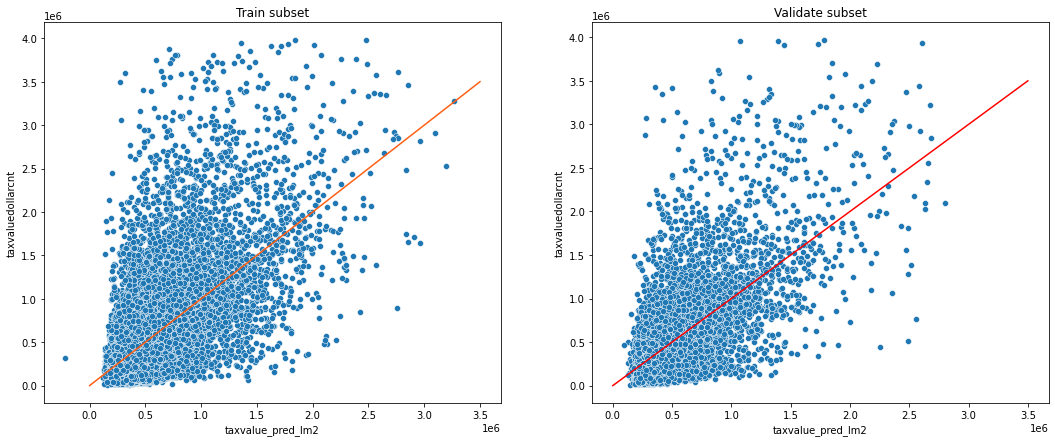

In [32]:
# finally, picture the train and validate for the chosen model
plt.figure(figsize=(18, 7))
plt.subplot(121)
sns.scatterplot(data = y_train, y = 'taxvaluedollarcnt', x = 'taxvalue_pred_lm2')
sns.lineplot(x=(0,3500000), y=(0,3500000), color = '#FF5E13')
plt.title('Train subset')


plt.subplot(122)
sns.scatterplot(data = y_validate, y = 'taxvaluedollarcnt', x = 'taxvalue_pred_lm2')
sns.lineplot(x=(0,3500000), y=(0,3500000), color = 'red')
plt.title('Validate subset')
plt.show()

<div class="alert alert-block alert-success">
    
### Takeaways
    
- The best model was the polynomial model
    
- The LassoLars model and the Linear Regression model performed about the same
<br>

# Conclusions and Moving Forward

<div class="alert alert-block alert-success">
    
### Key takeaways
    
- The factors that most drive tax value dollar count (from most to least important) are total square feet, bedroom count, age, and location
    
- Out of these models, I would recommend using the polynomial model to predict the tax value dollar count

### With more time
    
- Collect data that fills the null values in the data set
    
- Test the new variables in our model to see if we could beat the current polynomial regression model
    
- incorporate zip codes into our model
    
### Recommendations
    
- Focus on the square footage and bedroom count when attempting to calculate the value of the property
    
- Consider pursuing models that focus on smaller geographic areas, like zip codes, instead of one large model that covers a large variety factors. 
    
- Ensure that data is entered into columns to prevent an excess of null values, which is seen in many columns

<br>

With this information, we can attempt to predict home values through 2019-2020 <span style="color:red">unless something goes horribly wrong and there is a world wide pandemic or something like that which would never ACTUALLY happen..</span>